In [30]:
import os
import string
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

from PIL import Image
from pathlib import Path
from typing import Sequence
from matplotlib.figure import Figure
from matplotlib.gridspec import GridSpec
from matplotlib.axes import Axes
from random import randint
from IPython.display import display

from ba_dev.dataset import MammaliaDataSequence, MammaliaDataImage
from ba_dev.transform import ImagePipeline, BatchImagePipeline
from ba_dev.eval_helpers import *
from ba_dev.utils import load_path_yaml

paths = load_path_yaml('../../data/path_config.yml')

set_custom_plot_style()
cm = 1 / 2.54

export = False

## Loading dataset as sequences and images

In [2]:
label_files = paths['labels'].glob('*.csv')

raw_data = pd.DataFrame()

for label_file in label_files:
    new_data = pd.read_csv(label_file)
    raw_data = pd.concat([raw_data, new_data], ignore_index=True)

keys_to_keep = ['session', 'seq_id', 'Directory', 'n_files', 'all_files', 'label2']

all_sequences = raw_data[keys_to_keep].rename(columns={'label2': 'class_label'})

allowed_values = ['apodemus_sp', 'cricetidae', 'mustela_erminea', 'soricidae']

filtered_sequences = all_sequences[all_sequences['class_label'].isin(allowed_values)].copy()

filtered_sequences['all_files'] = filtered_sequences['all_files'].str.split(',')

filtered_sequences[['conf_values', 'bboxes', 'max_conf']] = (
    filtered_sequences
    .apply(
        lambda row: get_md_info(
            seq_id=row['seq_id'],
            files_list=row['all_files'],
            md_output_dir=paths['md_output']
        ),
        axis=1,
        result_type='expand'
    ))

sequence_df = filtered_sequences.copy()

image_df = (
    filtered_sequences
    .explode(['all_files', 'conf_values', 'bboxes'])
    .rename(columns={
        'all_files': 'file',
        'conf_values': 'conf_value',
        'bboxes': 'bbox'
        })
    .assign(path=lambda df: df['Directory'] + '/' + df['file'])
    .drop(columns=['max_conf', 'Directory'])
    .reset_index(drop=True)
    )


In [43]:
def draw_bbox_on_ax(
        ax: Axes,
        image: Image.Image,
        bbox: BBox | None = None,
        conf: float | None = None,
        offset_margin_conf_annotation: int = 100
        ) -> None:
    """
    Draw an image with a bounding box onto an existing Axes.

    Args:
        ax (Axes): The axes to draw into.
        image (Image.Image): The image to plot.
        bbox (BBox): Bounding box [x, y, w, h] in relative coords (0-1).
        conf (float, optional): Confidence score to annotate.
    """

    ax.imshow(image)
    draw_bbox = False

    if bbox is not None and (bbox[2] > 0 and bbox[3] > 0):
        draw_bbox = True

    if draw_bbox and bbox is not None:
        width, height = image.size
        x_abs, y_abs = bbox[0] * width, bbox[1] * height
        w_abs, h_abs = bbox[2] * width, bbox[3] * height

        rect = patches.Rectangle(
            (x_abs, y_abs), w_abs, h_abs,
            linewidth=1, edgecolor='red', facecolor='none'
        )
        ax.add_patch(rect)

        if conf:

            if x_abs + offset_margin_conf_annotation > width:
                ha, offset = 'right', (-2, 8)
                x = x_abs + w_abs

            else:
                ha, offset = 'left', (2, 8)
                x = x_abs

            ax.annotate(
                f"conf = {conf:.2f}",
                xy=(x, y_abs),
                xytext=offset,
                textcoords="offset points",
                ha=ha, va="top",
                fontsize=8, color="white",
                bbox=dict(facecolor="red", alpha=0.5, edgecolor="none", pad=1.5),
                clip_on=False
            )

    ax.axis('off')


def plot_series_of_images(
        df: pd.DataFrame,
        dataset_path: PathLike | str,
        ncols: int = 3,
        fig_width_cm: float = 24,
        offset_margin_conf_annotation: int = 100
        ) -> Figure:

    dataset_path = Path(dataset_path)

    fig_width = fig_width_cm / 2.54
    nrows = (len(df) + ncols - 1) // ncols
    labels = list(string.ascii_lowercase)

    fig = plt.figure(figsize=(fig_width, fig_width * nrows / ncols * 3/4))
    gs = GridSpec(
        nrows=nrows, 
        ncols=ncols,
        figure=fig,
        )

    for idx, (_, row) in enumerate(df.iterrows()):

        ax = fig.add_subplot(gs[idx // ncols, idx % ncols])

        file_path = dataset_path / row['path']

        img = Image.open(file_path)
        bbox = row['bbox']
        conf = row['conf_value']

        ax.annotate(
            f'({labels[idx]})',
            xy=(0.01, 0.98),
            xycoords=ax.transAxes,
            fontsize=10,
            color='red',
            ha='left',
            va='top',
            bbox=dict(facecolor='white', edgecolor='none', alpha=0.6, pad=1.5)
        )

        draw_bbox_on_ax(
            ax=ax, 
            image=img, 
            bbox=bbox, 
            conf=conf,
            offset_margin_conf_annotation=offset_margin_conf_annotation
            )

    plt.tight_layout()

    plt.close(fig)

    return fig


In [37]:
# filtered and sorted

start_id = 0
end_id = 12


filter = (image_df["conf_value"] >= 0.25) & (image_df["class_label"] == "mustela_erminea")
filtered_image_df = image_df.where(filter).dropna().sort_values(by='conf_value', ascending=True)

chunk = filtered_image_df.iloc[start_id:end_id]

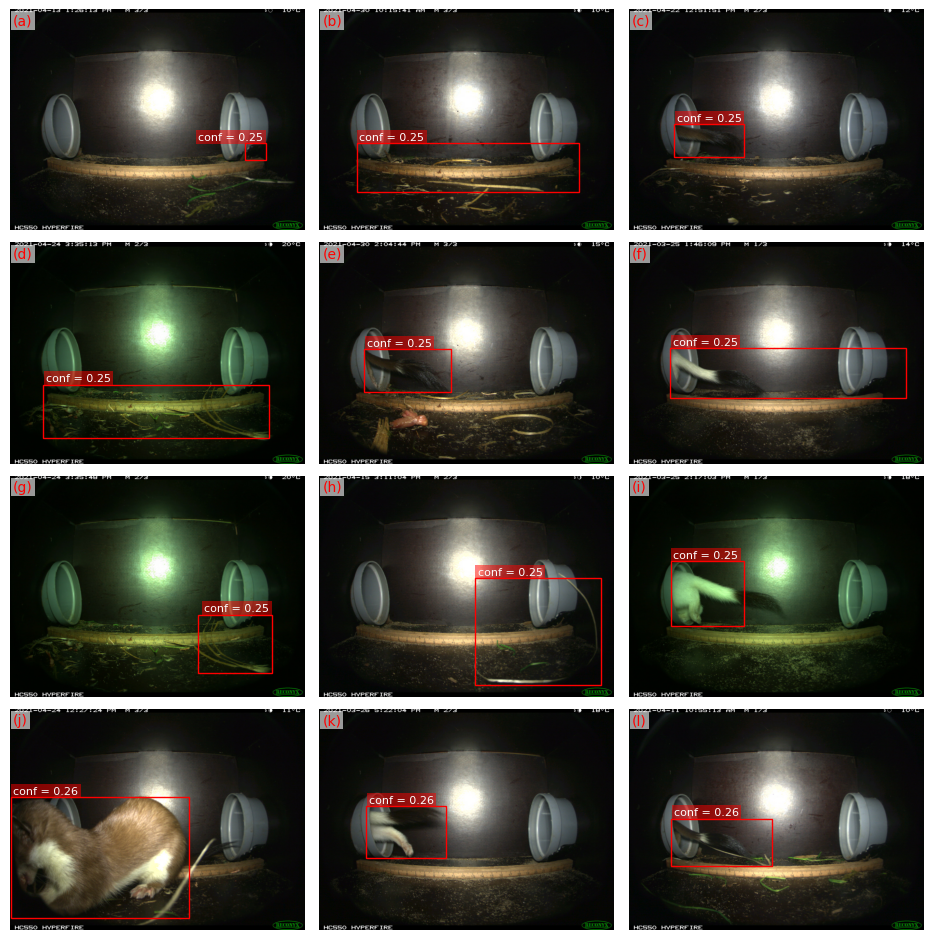

In [46]:
plot_series_of_images(
    df=chunk, 
    dataset_path=paths['dataset'], 
    ncols=3, 
    fig_width_cm=24,
    offset_margin_conf_annotation=800
    )

In [13]:
chunk

session     seq_id  n_files          file      class_label conf_value  \
429685      6.0  6000616.0      3.0  IMG_2559.JPG  mustela_erminea       0.25   
425547      6.0  6000225.0     78.0  IMG_3360.JPG  mustela_erminea       0.25   
434592      6.0  6000863.0    183.0  IMG_7466.JPG  mustela_erminea      0.251   
436560      6.0  6000936.0      6.0  IMG_9434.JPG  mustela_erminea      0.252   
426549      6.0  6000258.0    150.0  IMG_4362.JPG  mustela_erminea      0.252   
421849      6.0  6000064.0      6.0  IMG_0592.JPG  mustela_erminea      0.252   
436563      6.0  6000937.0      3.0  IMG_9437.JPG  mustela_erminea      0.252   
430038      6.0  6000642.0      3.0  IMG_2912.JPG  mustela_erminea      0.253   
421996      6.0  6000079.0      9.0  IMG_0739.JPG  mustela_erminea      0.253   
435982      6.0  6000906.0     66.0  IMG_8856.JPG  mustela_erminea      0.255   

                                    bbox  \
429685  [0.7963, 0.6054, 0.0722, 0.0781]   
425547  [0.1254, 0.6054, 0.7548, 0.2207]   
434592   [0.1523, 0.5188, 0.2368, 0.151]   
436560   [0.1123, 0.6432, 0.767, 0.2389]   
426549  [0.1523, 0.4817, 0.2949, 0.1966]   
421849  [0.1406, 0.4765, 0.7988, 0.2285]   
436563  [0.6362, 0.6282, 0.2529, 0.2623]   
430038   [0.5263, 0.4635, 0.4282, 0.483]   
421996   [0.1411, 0.3854, 0.249, 0.2962]   
435982  [0.0019, 0.3977, 0.6059, 0.5455]   

                                         path  
429685  sessions/session_06/Cam4/IMG_2559.JPG  
425547  sessions/session_06/Cam3/IMG_3360.JPG  
434592  sessions/session_06/Cam4/IMG_7466.JPG  
436560  sessions/session_06/Cam4/IMG_9434.JPG  
426549  sessions/session_06/Cam3/IMG_4362.JPG  
421849  sessions/session_06/Cam1/IMG_0592.JPG  
436563  sessions/session_06/Cam4/IMG_9437.JPG  
430038  sessions/session_06/Cam4/IMG_2912.JPG  
421996  sessions/session_06/Cam1/IMG_0739.JPG  
435982  sessions/session_06/Cam4/IMG_8856.JPG

In [5]:
# fixed list in fixed order

mustela_erminea_nodetect = [22374, 35835, 33248, 421320, 421394, 421465, 421507, 421590, 421664, 421712, 421959, 423864]
order = [0, 1, 2, 5, 6, 10, 11, 3, 4, 7, 8, 9]
mustela_erminea_nodetect = [mustela_erminea_nodetect[i] for i in order]

filtered_image_df = image_df.loc[mustela_erminea_nodetect]

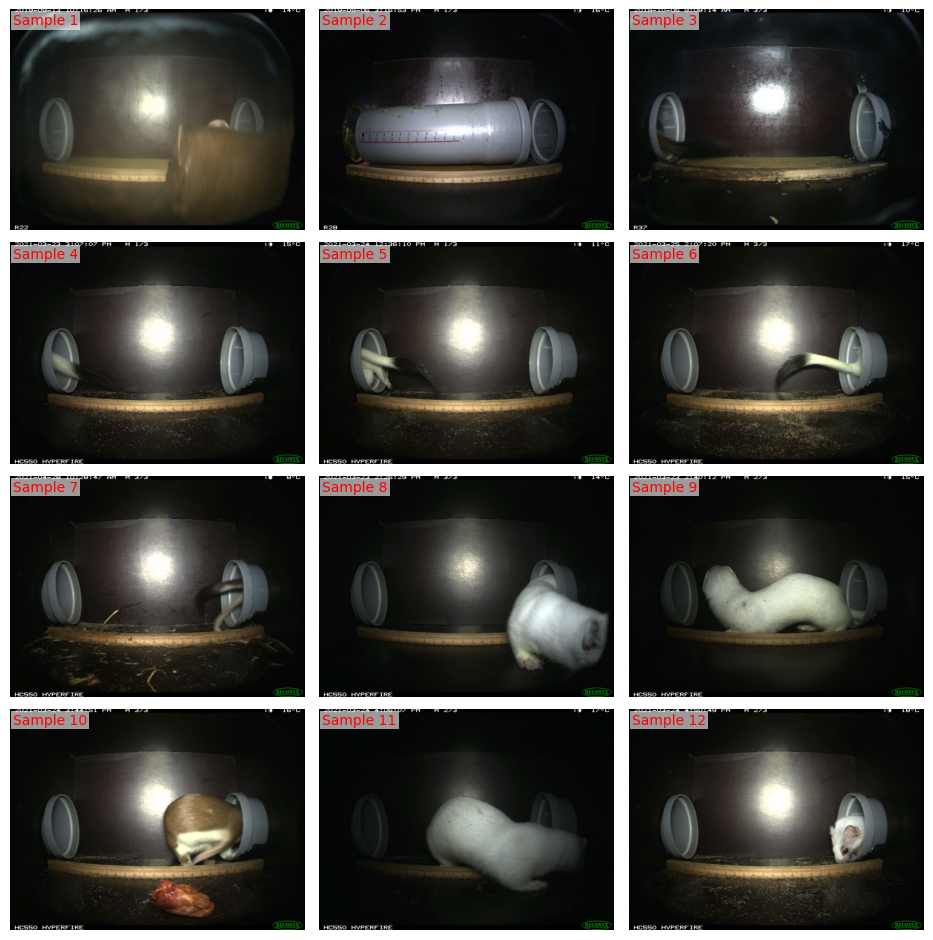

In [11]:
plot_series_of_images(filtered_image_df, ncols=3, fig_width_cm=24)

In [ ]:
# filtered and sorted

filter = (image_df["conf_value"] >= 0.5) & (image_df["class_label"] == "mustela_erminea")
filtered_image_df = image_df.where(filter).dropna().sort_values(by='conf_value', ascending=False)


In [ ]:
# set up for plotting chunks
chunk_size = 12
start_id = 0
end_id = start_id + chunk_size

n_chunks = (len(filtered_image_df) + chunk_size - 1) // chunk_size



Processing chunk 1 of 1


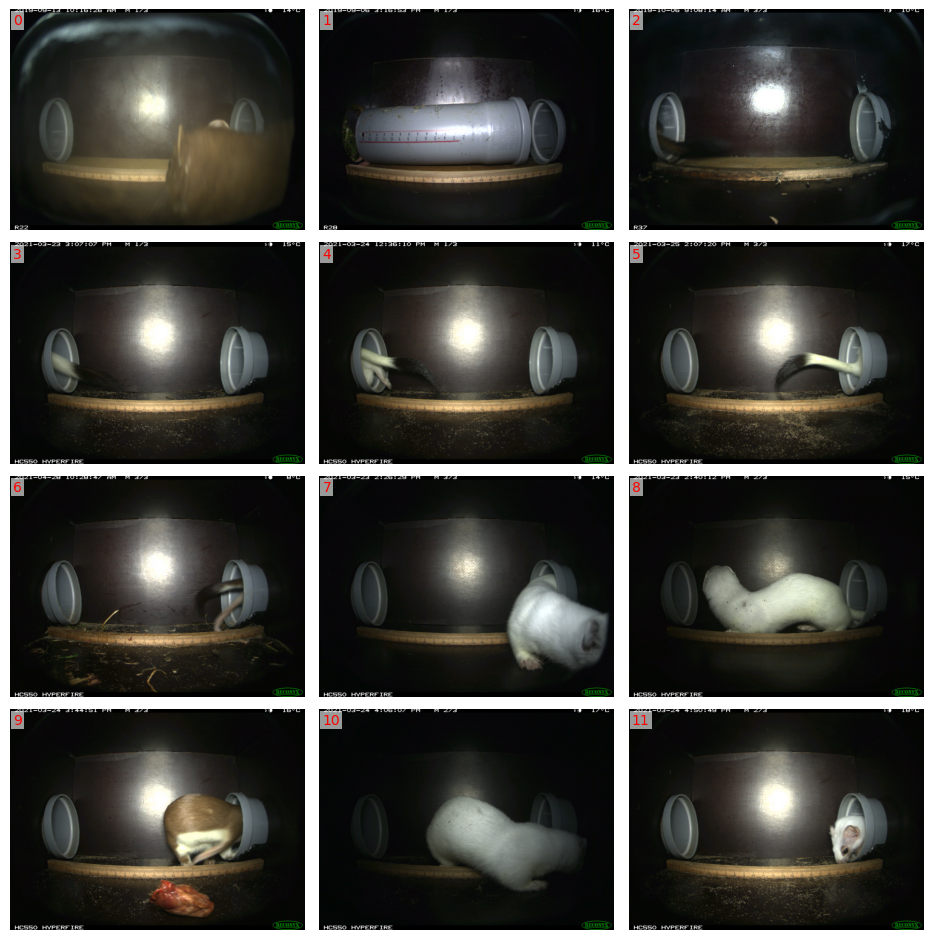

In [ ]:
# plotting chunks

current_chunk = end_id // chunk_size
print(f'Processing chunk {current_chunk} of {n_chunks}')
chunk = filtered_image_df.iloc[start_id:end_id]
start_id = end_id
end_id = start_id + chunk_size

fig_width = 24*cm
ncols = 3
nrows = (len(chunk) + ncols - 1) // ncols

fig = plt.figure(figsize=(fig_width, fig_width * nrows / ncols * 3/4))
gs = GridSpec(
    nrows=nrows, ncols=ncols,
    figure=fig,
    )

for idx, (_, row) in enumerate(chunk.iterrows()):

    ax = fig.add_subplot(gs[idx // ncols, idx % ncols])


    file_path = paths['dataset'] / row['path']

    img = Image.open(file_path)
    bbox = row['bbox']
    conf = row['conf_value']

    ax.annotate(
        f"{idx}",
        xy=(0.01, 0.98),
        xycoords=ax.transAxes,
        fontsize=10,
        color="red",
        ha="left",
        va="top",
        bbox=dict(facecolor="white", edgecolor="none", alpha=0.6, pad=1.5)
    )

    draw_bbox_on_ax(ax, img, bbox, conf)           

fig.tight_layout()

# fig.savefig(paths['figures'] / 'mustela_special_nodetect.pdf', dpi=300)
    

In [230]:
selected_indices = [11]

original_indices = [int(chunk.iloc[idx].name) for idx in selected_indices]

selected_original_indices.extend(original_indices)
    

In [231]:
selected_original_indices

[421723]

In [ ]:
mustela_erminea_nodetect = [22374,
 35835,
 33248,
 421320,
 421394,
 421421,
 421465,
 421507,
 421590,
 421664,
 421712,
 421723,
 421959,
 421970,
 421999,
 423864,
 424135,
 424270,
 424271,
 424273]

mustela_erminea_top_detections = [432320,
 454322,
 427474,
 428954,
 436892,
 422355,
 422353,
 431267,
 437328,
 427622,
 430406,
 436319]

mustela_erminea_just_above25 = [425547,
 421849,
 430038,
 435982,
 435993,
 425949,
 432241,
 435529,
 422629,
 424740,
 431837]

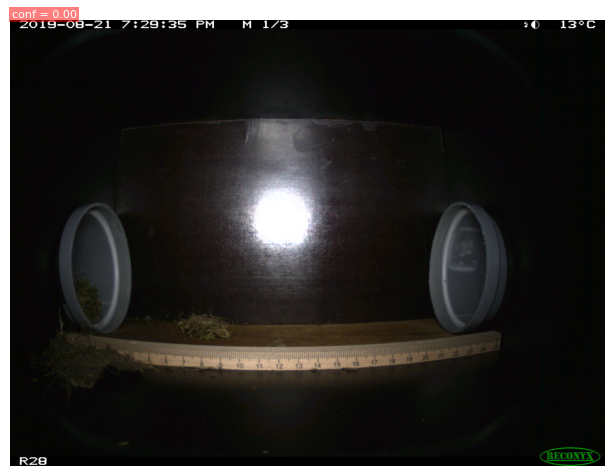

In [15]:
row = image_df.iloc[468949]

image = Image.open(paths['dataset'] / row['path'])
bbox = row['bbox']
conf = row['conf_value']


fig = plot_image_with_bbox(image=image, bbox=bbox, conf=conf)
display(fig)

## Outdated but saved

In [4]:
rais error

SyntaxError: invalid syntax (272083881.py, line 1)

In [25]:
scaling_factor = 0.5

image_pipeline = ImagePipeline(
                pre_ops=[
                    ('reduce_resolution', {'factor': scaling_factor})
                ]
                )

dataset_img = MammaliaDataImage(
    path_labelfiles=paths['labels'],
    path_to_dataset=paths['dataset'],
    path_to_detector_output=paths['md_output'],
    detector_model=None,
    mode='eval',
    image_pipeline=image_pipeline,
)

image_pipeline = BatchImagePipeline(
                pre_ops=[
                    ('reduce_resolution', {'factor': scaling_factor})
                ]
                )

dataset_seq = MammaliaDataSequence(
    path_labelfiles=paths['labels'],
    path_to_dataset=paths['dataset'],
    path_to_detector_output=paths['md_output'],
    detector_model=None,
    mode='eval',
    image_pipeline=image_pipeline,
)


/Users/jk/MyPythonPackages/BA_package/ba_dev/dataset.py:249: UserWarning: With the detection confidence of 0.25,
309 sequences had no detections and will be excluded.
Excluded sequences: [6000646, 6000663, 6000665, 6000679, 6000680, 6000681, 6000683, 4001841, 1001523, 6000691] ...
  warnings.warn(
/Users/jk/MyPythonPackages/BA_package/ba_dev/dataset.py:249: UserWarning: With the detection confidence of 0.25,
309 sequences had no detections and will be excluded.
Excluded sequences: [6000646, 6000663, 6000665, 6000679, 6000680, 6000681, 6000683, 4001841, 1001523, 6000691] ...
  warnings.warn(


In [26]:
df = dataset_img.ds.copy()

summary_df = (
    df.groupby('seq_id', group_keys=False)
      .agg(
          n_images=('conf', 'count'),
          min_conf=('conf', 'min'),
          max_conf=('conf', 'max')
      )
      .reset_index()
)
summary_df['conf_range'] = summary_df['max_conf'] - summary_df['min_conf']

summary_df_sorted = summary_df.sort_values(by='conf_range', ascending=False)


In [5]:
n_plots = 3
fig_width = 24*cm
target_path = Path('/cfs/earth/scratch/kraftjul/BA/output/conf_examples')

for seq_id in summary_df_sorted['seq_id'].tolist()[:n_plots]:

    i = dataset_seq.get_index_by_seq_id(seq_id)
    sequence = dataset_seq[i]

    length = len(sequence['sample'])

    if length >= 6:
        nrows = 3
        ncols = 2
    else:
        raise ValueError("The sequence is too short to be displayed in a 3x2 grid.")

    fig = plt.figure(figsize=(fig_width, fig_width * nrows / ncols * 3/4))
    gs = GridSpec(
        nrows=nrows, ncols=ncols,
        figure=fig,
        )

    for col in range(ncols):
        for row in range(nrows):
            ax = fig.add_subplot(gs[row, col])

            if col == 0:
                idx = row
            else:
                idx = -(nrows - row)

            img = sequence['sample'][idx]
            bbox = sequence['bbox'][idx]
            conf = sequence['conf'][idx]

            draw_bbox_on_ax(ax, img, bbox, conf)

    fig.tight_layout()



NameError: name 'summary_df_sorted' is not defined

In [28]:
seq_id_to_load = 4000575
i = dataset_seq.get_index_by_seq_id(seq_id_to_load)
sequence = dataset_seq[i]

In [29]:
len(sequence['sample'])

10

In [30]:
sequence['sample']

[<PIL.Image.Image image mode=RGB size=1024x768>,
 <PIL.Image.Image image mode=RGB size=1024x768>,
 <PIL.Image.Image image mode=RGB size=1024x768>,
 <PIL.Image.Image image mode=RGB size=1024x768>,
 <PIL.Image.Image image mode=RGB size=1024x768>,
 <PIL.Image.Image image mode=RGB size=1024x768>,
 <PIL.Image.Image image mode=RGB size=1024x768>,
 <PIL.Image.Image image mode=RGB size=1024x768>,
 <PIL.Image.Image image mode=RGB size=1024x768>,
 <PIL.Image.Image image mode=RGB size=1024x768>]

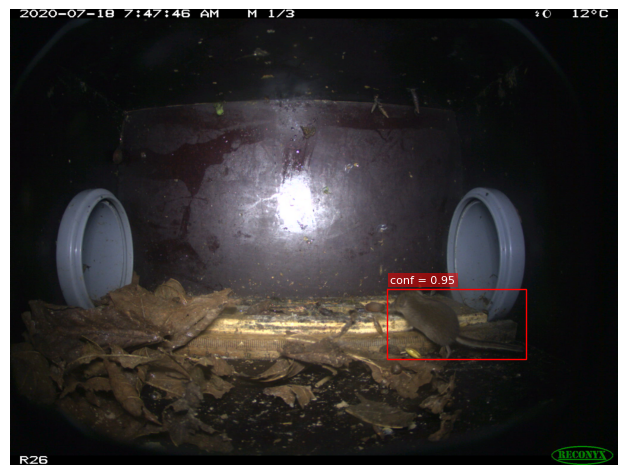

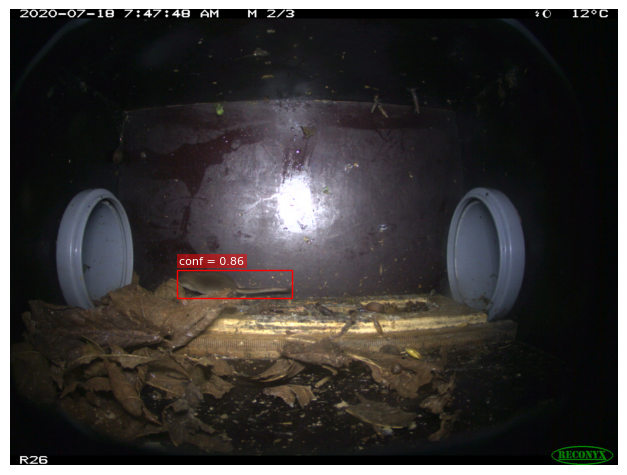

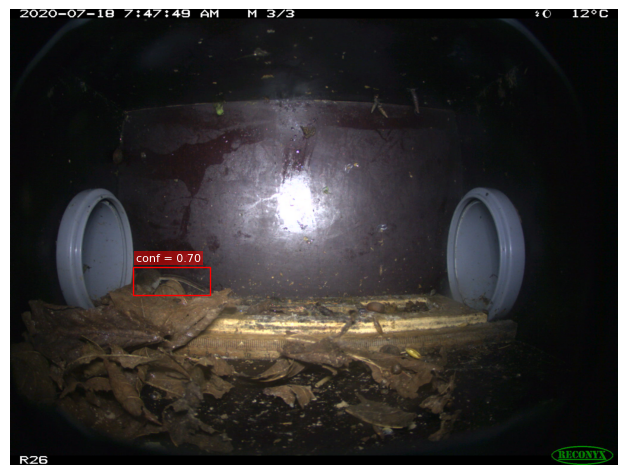

In [31]:
interessting_sequences = [4011876, 4018688]

i = dataset_seq.get_index_by_seq_id(interessting_sequences[1])
sequence = dataset_seq[i]

for image, bbox, conf in zip(sequence['sample'], sequence['bbox'], sequence['conf']):
    fig = plot_image_with_bbox(image=image, bbox=bbox, conf=conf)
    display(fig)

Randomly selected index: 422642
class_label: cricetidae
seq_id: 2000210


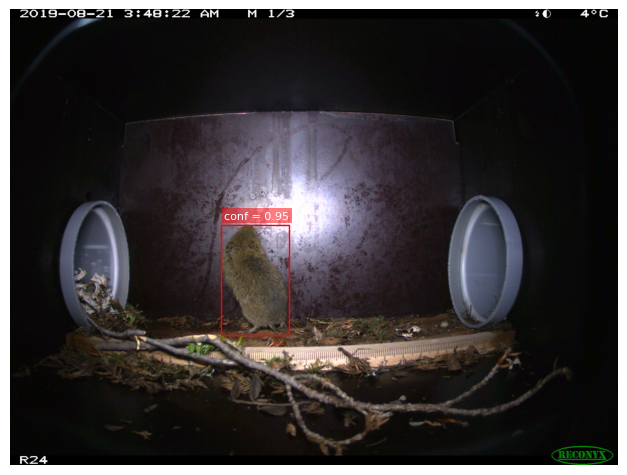

In [32]:
i = randint(0, len(dataset_img) - 1)
print(f"Randomly selected index: {i}")
sample = dataset_img[i]
print(f'class_label: {sample["class_label"]}')
print(f'seq_id: {sample["seq_id"]}')

fig = plot_image_with_bbox(image=sample['sample'], bbox=sample['bbox'], conf=sample['conf'])
display(fig)

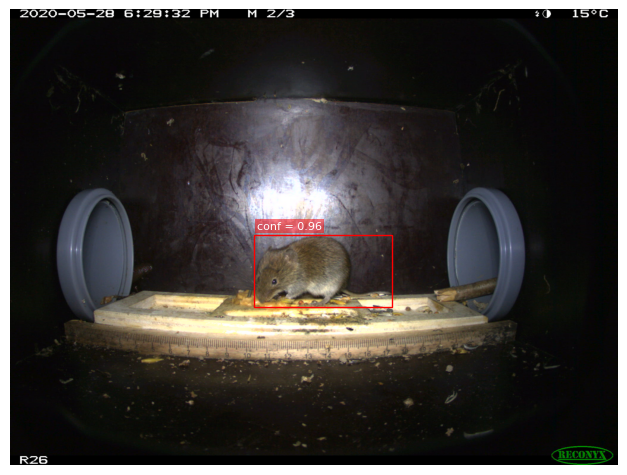

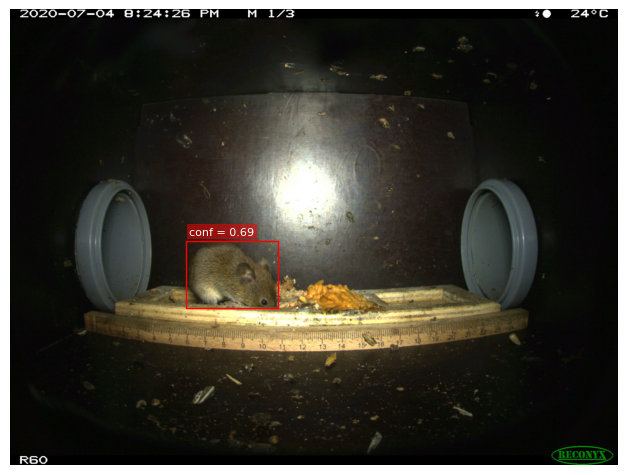

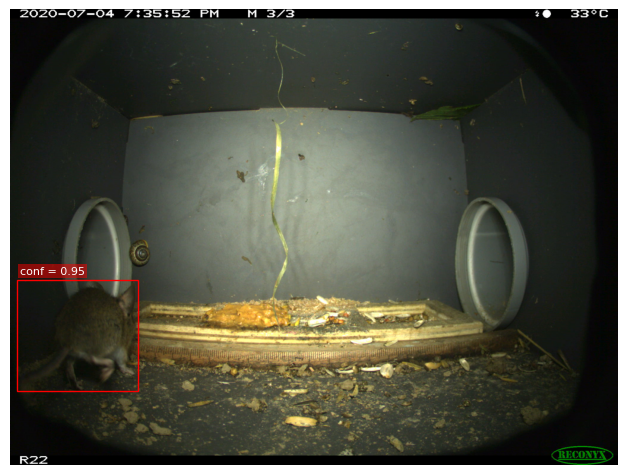

In [33]:
interesting_images = [108812, 340523, 319527]

for i in interesting_images:
    sample = dataset_img[i]
    figure = plot_image_with_bbox(image=sample['sample'], bbox=sample['bbox'], conf=sample['conf'])
    display(figure)

In [34]:
lowest_conf_indices = dataset_img.ds.nsmallest(5, 'conf').index.tolist()

for i in lowest_conf_indices:
    sample = dataset_img[i]
    figure = plot_image_with_bbox(image=sample['x'], bbox=sample['bbox'], conf=sample['conf'])
    display(figure)
    

KeyError: 'x'

In [ ]:
# Plot Fraction of Discarded Images by Applied Confidence
########################################################################################################################
fig_name = 'discarded_img_by_conf.pdf'
fig_size = (12*cm,7*cm)
conf_threshold = 0.5
scaling_factor = 0.5
########################################################################################################################

image_pipeline = ImagePipeline(
                pre_ops=[
                    ('reduce_resolution', {'factor': scaling_factor})
                ]
                )

dataset_img = MammaliaDataImage(
    path_labelfiles=paths['labels'],
    path_to_dataset=paths['dataset'],
    path_to_detector_output=paths['md_output'],
    detector_model=None,
    mode='eval',
    image_pipeline=image_pipeline,
)

df = dataset_img.ds

cdf_data = (
    df.sort_values(by='conf')
      .groupby('class_label', group_keys=False)
      .apply(lambda g: pd.DataFrame({
          'conf': np.sort(g['conf'].to_numpy()),
          'cum_density': np.linspace(0, 1, len(g)),
          'class_label': g.name  # this is the current group label
      }), include_groups=False)
      .reset_index(drop=True)
)

# Plotting
class_counts = df['class_label'].value_counts().to_dict()

plt.figure(figsize=fig_size)
for class_label, group in cdf_data.groupby('class_label'):
    count = class_counts.get(class_label, 0)
    label = f'{class_label} (n={count/1000:.1f}K)'
    
    line, = plt.plot(group['conf'], group['cum_density'], label=label)

    above_thresh = group[group['conf'] >= conf_threshold]
    if not above_thresh.empty:
        y_at_thresh = above_thresh['cum_density'].iloc[0]
        plt.hlines(y=y_at_thresh, xmin=0.24, xmax=conf_threshold, linestyle='--', alpha=0.5, color=line.get_color())

plt.axvline(x=conf_threshold, linestyle='--', color='gray', alpha=0.5)
plt.text(
    x=conf_threshold, y=1.08,
    s=f'Confidence Threshold = {conf_threshold}',
    horizontalalignment='center',
    fontsize=8,
    color='gray'
)

plt.xlabel('Applied Confidence')
plt.ylabel('Fraction of Images Discarded (log scale)')
plt.yscale('log')
plt.yticks(
    [0.01, 0.02, 0.03, 0.05, 0.07, 0.1, 0.2, 0.5, 1], 
    labels=['1%', '2%', '3%', '5%', '7%', '10%', '20%', '50%', '100%']
    )
plt.legend(
    loc='lower right',
    bbox_to_anchor=(1, -0.03),
    frameon=False
)
plt.xlim(left=0.24, right=1)
plt.ylim(bottom=0.01, top=1)
plt.tight_layout()
    
plt.show()

In [ ]:
# Plot Fraction of Discarded Sequences by Applied Confidence
########################################################################################################################
fig_name = 'discarded_seq_by_conf.pdf'
fig_size = (12*cm,7*cm)
conf_threshold = 0.5
########################################################################################################################

seq_class_conf = (
    df.groupby(['class_label', 'seq_id'])['conf']
      .max()
      .reset_index(name='max_conf')
    )
cdf_parts = []

for class_label, group in seq_class_conf.groupby('class_label'):
    conf_sorted = np.sort(group['max_conf'].to_numpy())
    cum_density = np.linspace(0, 1, len(conf_sorted))

    part_df = pd.DataFrame({
        'class_label': class_label,
        'max_conf': conf_sorted,
        'cum_density': cum_density
    })

    cdf_parts.append(part_df)

cdf_seq = pd.concat(cdf_parts, ignore_index=True)

seq_counts = seq_class_conf['class_label'].value_counts().to_dict()

plt.figure(figsize=fig_size)
for class_label, group in cdf_seq.groupby('class_label'):
    count = seq_counts.get(class_label, 0)
    label = f"{class_label} (n={count/1000:.1f}K)"
    
    line, = plt.plot(group['max_conf'], group['cum_density'], label=label)

    # Horizontal marker at the confidence threshold
    above_thresh = group[group['max_conf'] >= conf_threshold]
    if not above_thresh.empty:
        y_at_thresh = above_thresh['cum_density'].iloc[0]
        plt.hlines(y=y_at_thresh, xmin=0.24, xmax=conf_threshold, linestyle='--', alpha=0.5, color=line.get_color())

# Global reference lines
plt.axvline(x=conf_threshold, linestyle='--', color='gray', alpha=0.5)
plt.text(
    x=conf_threshold, y=1.08,
    s=f'Confidence = {conf_threshold}',
    horizontalalignment='center',
    fontsize=8,
    color='gray'
)

# Axes styling
plt.xlabel("Applied Confidence")
plt.ylabel("Fraction of Sequences Discarded (log scale)")
plt.yscale('log')
plt.yticks(
    [0.01, 0.02, 0.03, 0.05, 0.07, 0.1, 0.2, 0.5, 1],
    labels=['1%', '2%', '3%', '5%', '7%', '10%', '20%', '50%', '100%']
    )
plt.legend(frameon=False)
plt.xlim(left=0.24, right=1)
plt.ylim(bottom=0.002, top=1)
plt.tight_layout()

plt.show()